In [168]:
import tensorflow as tf
import keras

import os

from keras.utils import image_dataset_from_directory, load_img
from keras.optimizers import Adam

from keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [208]:
#today
#TODO implement data augmentation
#TODO add class labels to image loading
#TODO streamline functions

#tmr
#TODO improve model overfitting (lower drop out)



In [151]:
img_shape = (48,48)
BS = 16
dir_images = 'data/Training'

train_ds = image_dataset_from_directory(
    dir_images,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=img_shape,
    batch_size=BS,
    color_mode = 'grayscale'
)

val_ds = image_dataset_from_directory(
    dir_images,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=img_shape,
    batch_size=BS,
    color_mode = 'grayscale'

)

Found 27463 files belonging to 7 classes.
Using 21971 files for training.
Found 27463 files belonging to 7 classes.
Using 5492 files for validation.


In [159]:
test_ds = image_dataset_from_directory(
    'data/Test',
    seed=1337,
    image_size=img_shape,
    batch_size=BS,
    color_mode = 'grayscale'

)

Found 6570 files belonging to 7 classes.


In [152]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

shallow_sequence = [
    
    layers.Rescaling(1./255, input_shape=(img_shape+(1,))),
    
    #layer 1
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"), #stride size = 1
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    #layer 2
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"), #stride size = 1
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),


    #FC layer
    layers.Flatten(),
    layers.Dense(512, activation='relu'),

    #logistic layer
    layers.Dense(num_cat, activation='softmax')

  ]

In [156]:
def facial_expr_model(sequence):

    model = keras.Sequential(sequence)
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

In [157]:
model = facial_expr_model(shallow_sequence)
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 48, 48, 1)         0         
                                                                 
 conv2d_50 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_44 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_44 (Dropout)        (None, 46, 46, 32)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                

In [158]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=4
)

Epoch 1/4
1374/1374 [==============================] - 483s 350ms/step - loss: 2.2298 - accuracy: 0.3433 - val_loss: 1.7377 - val_accuracy: 0.3407
Epoch 2/4
1374/1374 [==============================] - 450s 327ms/step - loss: 1.4829 - accuracy: 0.4281 - val_loss: 1.5933 - val_accuracy: 0.3988
Epoch 3/4
1374/1374 [==============================] - 485s 353ms/step - loss: 1.3678 - accuracy: 0.4800 - val_loss: 1.5314 - val_accuracy: 0.4029
Epoch 4/4
1374/1374 [==============================] - 456s 332ms/step - loss: 1.2408 - accuracy: 0.5393 - val_loss: 1.5637 - val_accuracy: 0.4385


In [182]:
def eval_model(history):
    # Evaluate the model
    loss, acc = model.evaluate(test_ds, verbose=2)
    print("Accuracy: {:5.2f}%".format(100 * acc))
    


def plot_model_peformance(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    

In [191]:
def predict_image(image_path, model):

    img = tf.keras.utils.load_img(
    image_path, target_size=img_shape, color_mode = 'grayscale'
    )
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(np.argmax(score), 100 * np.max(score))
    )

In [205]:
def save_model_weights(model, model_id):
    model.save(f'my_model_{model_id}', save_format='h5')

411/411 - 18s - loss: 1.5582 - accuracy: 0.4320 - 18s/epoch - 43ms/step
Accuracy: 43.20%


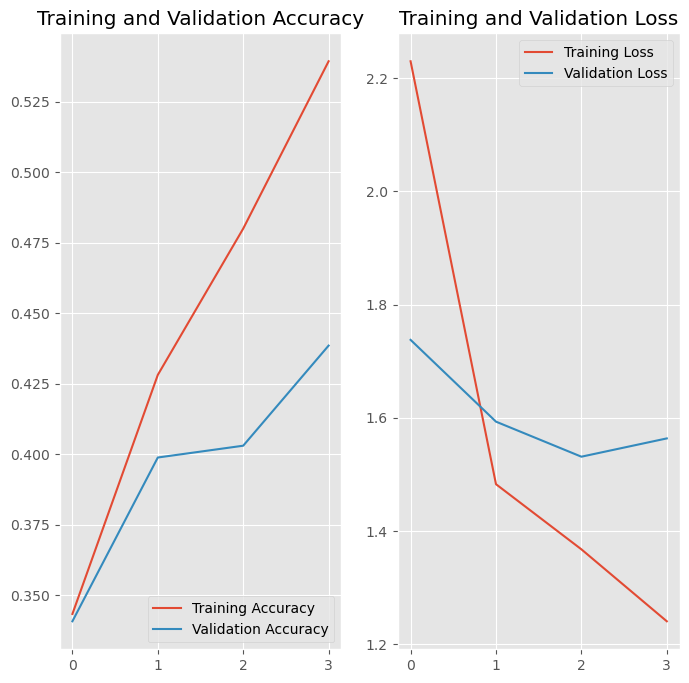

In [207]:
eval_model(history)
plot_model_peformance(history, 4)

In [203]:
# save_model_weights(model, 1)